# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
#Imports
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
#other setup
tfds.disable_progress_bar()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The steam reviews data used initially here is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [196]:
dataset = pd.read_csv('reviews_5000games_df')
#sample from dataset for ease of use
dataset = dataset.sample(frac=0.1, random_state=0)
dataset['voted_up'] = dataset['voted_up'].astype(int)
dataset['review'] = dataset['review'].astype(str)
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(train_dataset.columns)
#only need the review and the votes for now
train_dataset = train_dataset[['review', 'voted_up']]
test_dataset = test_dataset[['review', 'voted_up']]
train_dataset.head()

(2942, 26)
Index(['Unnamed: 0', 'AppId', 'recommendationid', 'author.steamid',
       'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played',
       'author.deck_playtime_at_review', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'primarily_steam_deck', 'timestamp_dev_responded',
       'developer_response'],
      dtype='object')


,review,voted_up
25306,Great game!\r\nKilling zombies + destroying ev...,1
16914,"Really cool shmup, probably the best in the Ze...",1
3358,"Very fun and enjoyable game for those who, lik...",1
22640,A decent indie platformer that focuses more on...,1
35072,Although REVERSE SIDE looks superb and it has ...,0


In [197]:
#convert to tfds
tf_train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
#tf_train_dataset = tf.convert_to_tensor(train_dataset)
tf_test_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
tf_train_dataset.element_spec

{'review': TensorSpec(shape=(), dtype=tf.string, name=None),
 'voted_up': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [198]:
for elem in tf_train_dataset.take(1):
  print('Review: ', elem['review'].numpy())
  print('Voted Up: ', elem['voted_up'].numpy())

Review:  b'Great game!\r\nKilling zombies + destroying everything in the office is the perfect anti-stress medicine.\r\nIt kept surprising me with new gameplay, definitely worth the money.\r\n'
Voted Up:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [199]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [200]:
tf_train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [201]:
for element in tf_train_dataset.take(1):
  print('texts: ', element['review'].numpy()[:3])
  print()
  print('labels: ', element['voted_up'].numpy()[:3])

texts:  [b"This is a tough call because of the low price ($2.00) but I can't recommend.  I haven't quite finished but here's what you get: a pretty nice opening screen artwork of a Japanese urban street, 12 sudoku puzzles of newspaper quality of about Wednesday/Thursday difficulty, and twelve colorized panels from a mildly sexualized manga, most showing a young couple.  Also some synth type music which is nice at first but wearing over the course of the puzzle solving. Depends on whether you are willing to shell out two bucks for 12 sudokus."
 b'Extremely relaxing and pleasant conservation game. I wish I could have a thousand more maps to play.'
 b'"Along the Edge" was a great experience for me. I\'ve played it twice already and I will surely play again in the future, just to see more of the possible outcomes. The game itself is short - one playthrough takes about 2 hours, but in my opinion, it\'s well worth the price. Writing is solid, protagonist is interesting, choices are not obvio

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

There is room for improvement here, vectorization with certain dictionaries or parameters may affect model accuracy.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [202]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_train_dataset.map(lambda x: x['review']))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

Note: Should filter for significant tokens. 'a' and 'the' and 'in' and so on are not helpful.

In [203]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'to', 'game', 'i', 'of', 'it',
       'is', 'you', 'this', 'in', 'for', 'that', 'but', 'with', 'are',
       'its'], dtype='<U325')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [204]:
encoded_example = encoder(element['review'])[:3].numpy()
encoded_example

array([[  12,   10,    4, ...,    0,    0,    0],
       [ 458,  742,    3, ...,    0,    0,    0],
       [ 671,    2, 1534, ...,    0,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [205]:
for n in range(3):
  print("Original: ", element['review'][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is a tough call because of the low price ($2.00) but I can't recommend.  I haven't quite finished but here's what you get: a pretty nice opening screen artwork of a Japanese urban street, 12 sudoku puzzles of newspaper quality of about Wednesday/Thursday difficulty, and twelve colorized panels from a mildly sexualized manga, most showing a young couple.  Also some synth type music which is nice at first but wearing over the course of the puzzle solving. Depends on whether you are willing to shell out two bucks for 12 sudokus."
Round-trip:  this is a tough call because of the low price 200 but i cant recommend i havent quite finished but heres what you get a pretty nice opening screen artwork of a japanese urban street 12 sudoku puzzles of [UNK] quality of about wednesdaythursday difficulty and twelve [UNK] panels from a mildly sexualized manga most showing a young couple also some synth type music which is nice at first but wearing over the course of the puzzle solvin

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [206]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [207]:
print([layer.supports_masking for layer in model.layers])

[True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [208]:
# predict on a sample text without padding.

sample_text = "The game was cool. The animation and the graphics were out of this world. I would recommend this game."
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)

# Exapanded layers to see output
layer2 = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
layer2_output = layer2(encoded_example)

layer3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
layer3_output = layer3(layer2_output)

layer4 = tf.keras.layers.Dense(64, activation='relu')
layer4_output = layer4(layer3_output)

layer5 = tf.keras.layers.Dense(1)
layer5_output = layer5(layer4_output)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
[-0.00010233]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [209]:
# predict on a sample text with padding

padding = "the " * 2000
encoded_padding = tf.expand_dims(encoder(padding), axis=0)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
[-0.00010233]


## Train the model

In [210]:
encoded_train_dataset = tf_train_dataset.map(lambda x: (encoder(x['review']), x['voted_up']))
encoded_test_dataset = tf_test_dataset.map(lambda x: (encoder(x['review']), x['voted_up']))

history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
21/46 ━━━━━━━━━━━━━━━━━━━━ 8:26 20s/step - accuracy: 0.3205 - loss: 0.6565

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8602 - loss: 0.4267
Test Loss: 0.41725778579711914
Test Accuracy: 0.8622000217437744


(0.0, 0.6258400674909353)

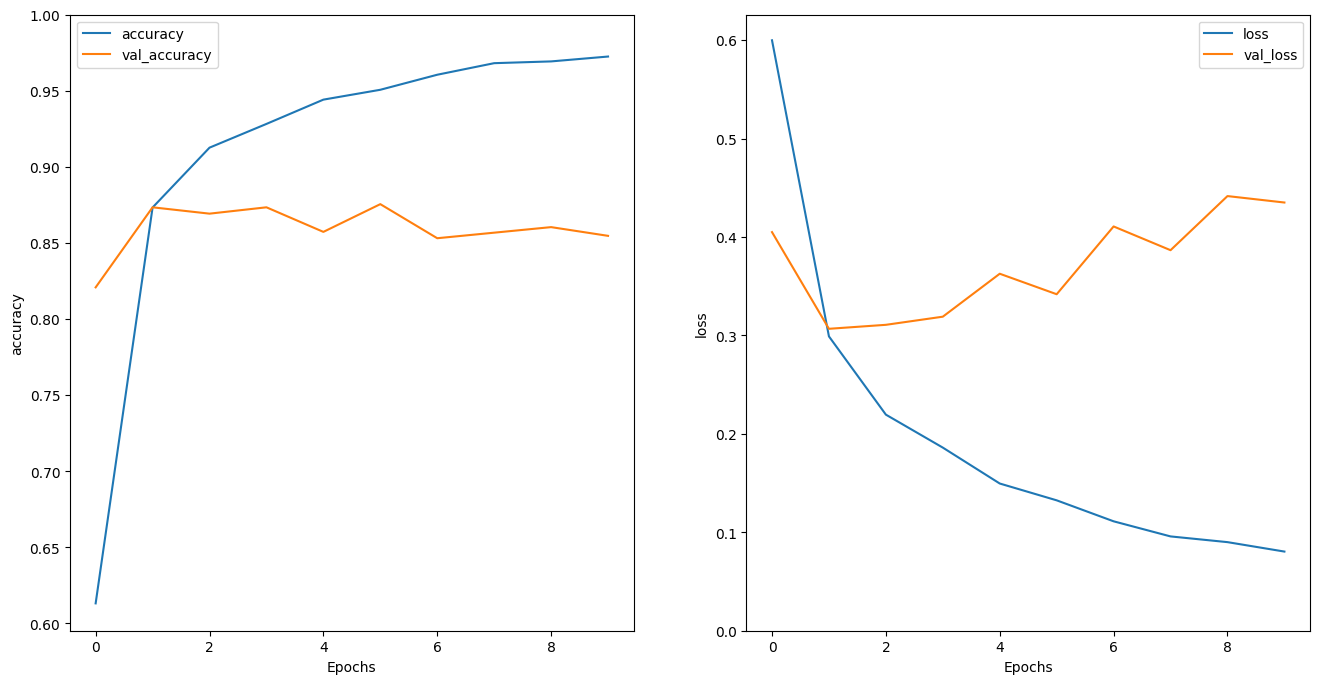

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[2.0658996]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.5416 - loss: 0.6570 - val_accuracy: 0.8120 - val_loss: 0.3697
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 114ms/step - accuracy: 0.8763 - loss: 0.3062 - val_accuracy: 0.8453 - val_loss: 0.3370
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.9178 - loss: 0.2155 - val_accuracy: 0.8594 - val_loss: 0.3304
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 210ms/step - accuracy: 0.9387 - loss: 0.1747 - val_accuracy: 0.8724 - val_loss: 0.3247
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 209ms/step - accuracy: 0.9534 - loss: 0.1385 - val_accuracy: 0.8693 - val_loss: 0.3543
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.9649 - loss: 0.1137 - val_accuracy: 0.8760 - val_loss: 0.4237
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.9704 - loss: 0.0986 - val_accuracy: 0.8521 - val_loss: 0.4866
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.9760 - loss: 

In [ ]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8615 - loss: 0.5367
Test Loss: 0.5306323766708374
Test Accuracy: 0.8627200126647949


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
[[-2.487583]]


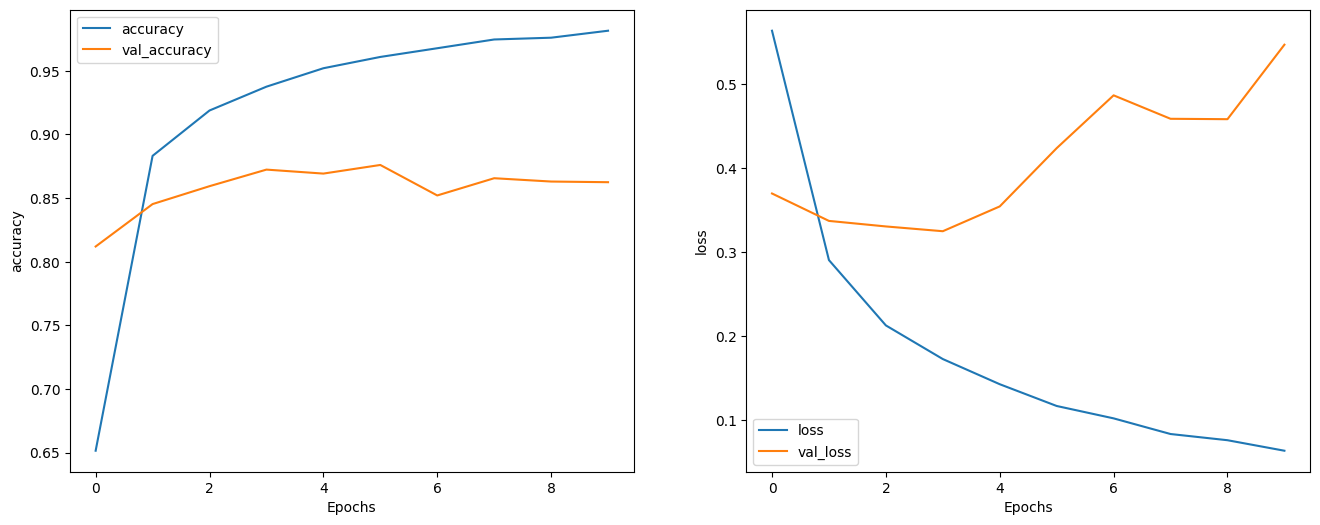

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
